In [69]:
import numpy as np
import dwave.inspector
from dwave.system import DWaveSampler
import pickle
import pandas as pd
from pathlib import Path  
from datetime import datetime
import matplotlib.pyplot as plt
import os
import dimod
import networkx as nx
import dwave_networkx as dnx
import h5py

from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
import geopandas as gpd
from minorminer import find_embedding


from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')


def set_params_array(paramsdict):
    paramsarray = np.array([list(paramsdict.keys()), list(paramsdict.values())])
    return paramsarray

def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

In [3]:

# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

#get the couplers and nodes available in the qpu
couplers_avail = np.array(sampler.edgelist)
nodes_avail = np.array(sampler.nodelist)

target_graph = nx.Graph()
target_graph.add_nodes_from(nodes_avail)
target_graph.add_edges_from(couplers_avail)

QPU Advantage2_prototype1.1 was selected.


# load data

First, functions to measure the total magnetization per rep, and then to measure the total bond energy.

In [26]:
def magnetization_per_sample(Npts, resps, embedding, variables):
    mags = []
    # broken = []
    num_broken = []
    mags_per_site = np.zeros(Npts)
    for k in range(len(resps)):
        ind_mag = 0
        ind_broken = 0
        for site in embedding.keys():
            embedding[site][0]
            if len(embedding[site]) == 2:
                site1 = np.where(variables == embedding[site][0])[0]
                site2 = np.where(variables == embedding[site][1])[0]
                if resps[k][site1] == resps[k][site2]:
                    # broken.append('good')
                    ind_mag += resps[k][site1]
                    mags_per_site[site] += resps[k][site1]
                else:
                    # broken.append('broken')
                    ind_broken += 1
                    ind_mag += 0
            else:
                # print(embedding[site])
                site1 = np.where(variables == embedding[site][0])[0]
                # print(site1)
                ind_mag += resps[k][site1]
                mags_per_site[site] += resps[k][site1]

            # site1 = np.where(variables == embedding[site][0])[0]
            # # print(site1)
            # ind_mag += resps[k][site1]

        # print(ind_mag)

        mags.append(ind_mag)
        num_broken.append(ind_broken)
    return mags, num_broken, mags_per_site/len(resps)

def energy_per_sample(resps, embedding, variables, all_edges):

    ene = []
    for k in range(len(resps)):
        ind_ene = 0
        for edge in all_edges:
            # if len(embedding[site]) == 2:
            site1 = np.where(variables == embedding[edge[0]][0])[0]
            site2 = np.where(variables == embedding[edge[1]][0])[0]
            ind_ene += resps[k][site1]*resps[k][site2]
            # else:
            #     site1 = np.where(variables == embedding[edge[0]])[0]
            #     site2 = np.where(variables == embedding[edge[1]])[0]
            #     ind_ene += resps[k][site1]*resps[k][site2]
        ene.append(ind_ene)

    return ene

Data for a given temperature and lattice size.

In [40]:
# rep = 57
Npts = 20
beta = 1
Nreps = 100
mags_per_site_total = []
list_mag_rand_trig = []
list_ene_rand_trig = []
for rep in range(Nreps):
    data_extract = np.load('./data/raw/Npts={:.0f}/beta={}/forward_anneal_sol_{:.0f}.npz'.format(Npts, beta, rep), allow_pickle=True)

    save_embedding = data_extract['embedding'][()]
    variab = data_extract['variables']
    resps_total = data_extract['resp']
    mags, numbroken, mags_per_site = magnetization_per_sample(Npts, resps_total, save_embedding, variab)
    mags_per_site_total.append(mags_per_site) #this is triangulation-specific

    # print("avg mag_Z : ", np.mean(mags)/len(save_embedding))
    # print("avg |mag_Z| : ", np.mean(np.abs(mags))/len(save_embedding))
    list_mag_rand_trig.extend(list(map(lambda x: x//len(save_embedding), mags)))

    all_edges = data_extract['triangulation_edges']
    energy = energy_per_sample(resps_total, save_embedding, variab, all_edges)

    # print('avg bond energy :', np.mean(energy)/len(all_edges))
    list_ene_rand_trig.extend(list(map(lambda x: x//len(all_edges), energy)))


print("avg mag_Z : ", np.mean(list_mag_rand_trig))
print("avg |mag_Z| : ", np.mean(np.abs(list_mag_rand_trig)))
print('avg bond energy :', np.mean(list_ene_rand_trig))



avg mag_Z :  -0.377
avg |mag_Z| :  0.511
avg bond energy : 0.1198


Extract and process all data, saved in an hdf5 file. 

In [117]:

Nreps = 100
beta_range = [1, 0.5, 0.1, 0.03]
npts_range = [20, 50]
where_to_save = "./data/processed/"
filename_hs = where_to_save + "data_complete.hdf5"

folder = Path(where_to_save)
folder.mkdir(parents=True, exist_ok=True)

try:
    os.remove(filename_hs)
except OSError:
    pass

with h5py.File(Path(filename_hs), "w") as f:
    first_group = f.create_group("ranges")
    first_group.create_dataset("Npts", data = npts_range)
    first_group.create_dataset("beta_range", data = beta_range)
    
    for beta in beta_range:
        for Npts in npts_range:
            mags_per_site_total = []
            list_mag_rand_trig = []
            list_ene_rand_trig = []
            full_data = f.create_group("Npts={:.0f}_beta={:.2f}".format(Npts, beta))
            for rep in range(Nreps):
                data_extract = np.load('./data/raw/Npts={:.0f}/beta={}/forward_anneal_sol_{:.0f}.npz'.format(Npts, beta, rep), allow_pickle=True)

                save_embedding = data_extract['embedding'][()]
                variab = data_extract['variables']
                resps_total = data_extract['resp']
                mags, numbroken, mags_per_site = magnetization_per_sample(Npts, resps_total, save_embedding, variab)
                mags_per_site_total.append(mags_per_site) #this is triangulation-specific

                # print("avg mag_Z : ", np.mean(mags)/len(save_embedding))
                # print("avg |mag_Z| : ", np.mean(np.abs(mags))/len(save_embedding))
                list_mag_rand_trig.extend(list(map(lambda x: x//len(save_embedding), mags)))

                all_edges = data_extract['triangulation_edges']
                energy = energy_per_sample(resps_total, save_embedding, variab, all_edges)

                # print('avg bond energy :', np.mean(energy)/len(all_edges))
                list_ene_rand_trig.extend(list(map(lambda x: x//len(all_edges), energy)))

            full_data.create_dataset('mags', data= list_mag_rand_trig)
            full_data.create_dataset('enes', data= list_ene_rand_trig)


            # with h5py.File(Path(filename_hs), "w") as f:
            #     full_data = f.require_group("Npts=" + str(Npts) + "/beta=" + str(beta))
            #     full_data.create_dataset('mags', data= list_mag_rand_trig)
            #     full_data.create_dataset('enes', data= list_ene_rand_trig)


# Network graph visual of a single triangulation site-average

Load a given triangulation and observe the magnetization per site.

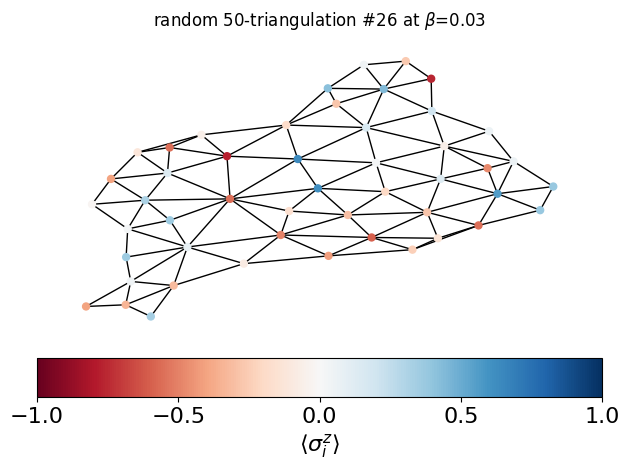

In [67]:
Npts = 50
beta = 0.03
rep = 26
data_extract = np.load('./data/raw/Npts={:.0f}/beta={}/forward_anneal_sol_{:.0f}.npz'.format(Npts, beta, rep), allow_pickle=True)

save_embedding = data_extract['embedding'][()]
variab = data_extract['variables']
resps_total = data_extract['resp']
mags, numbroken, mags_per_site = magnetization_per_sample(Npts, resps_total, save_embedding, variab)

# spring layout for easier visual
plot_graph = nx.Graph()
plot_graph.add_edges_from(data_extract['triangulation_edges'])
plot_graph.add_nodes_from(data_extract['triangulation_nodes'])


f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,0.5]})
cmap = plt.colormaps['RdBu']
colors = []
for node in plot_graph.nodes():
    # if node == 87:
    #     # colors.append('black')
    #     # colors.append(cmap((mags_per_site[node] + 1)/2))
    # else:
    #     colors.append(cmap((mags_per_site[node] + 1)/2))
    colors.append(cmap((mags_per_site[node] + 1)/2))

pos=nx.spring_layout(plot_graph, k=1, iterations=1000)
nx.draw(plot_graph, pos, node_size = 25, node_color = colors, ax = a0)
a0.set_title(r'random {:.0f}-triangulation #{:.0f} at $\beta$={:.2f}'.format(Npts, rep, beta))


# fig, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)
cmap = cm.get_cmap('RdBu')
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
cb1 = mpl.colorbar.ColorbarBase(a1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label(r'$\langle \sigma_i^z \rangle$', fontsize = 16)
cb1.set_ticks([-1, -0.5, 0, 0.5, 1.0])
cb1.ax.tick_params(labelsize=16)

f.tight_layout()
f.show()

# graphs of observables - random averaged

In [118]:
where_to_save = "./data/processed/"
filename_hs = where_to_save + "data_complete.hdf5"
data = h5py.File(filename_hs, 'r')

beta_range = np.array(data['ranges']['beta_range'])
npts_range = np.array(data['ranges']['Npts'])

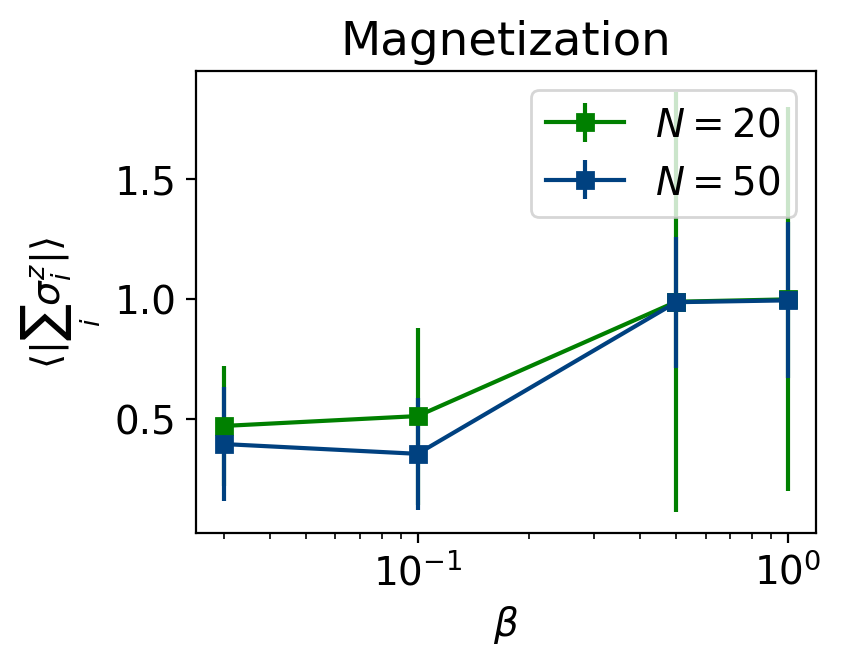

In [142]:
cmap = plt.colormaps['ocean']
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size':14})
plt.figure(figsize=(4,3))

for i in range(len(npts_range)):
    yarr = np.zeros(len(beta_range))
    yerr = np.zeros(len(beta_range))
    for j in range(len(beta_range)):    
        mag_array = np.array(data["Npts={:.0f}_beta={:.2f}".format(npts_range[i], beta_range[j])]['mags'])
        yarr[j] = np.mean(np.abs(mag_array))
        # yarr[j] = np.mean(mag_array)
        yerr[j] = np.mean(mag_array**2) -  (np.mean(mag_array))**2
    plt.errorbar(beta_range, yarr, yerr = yerr, fmt = 's-', label = r'$N = ${:.0f}'.format(npts_range[i]), color = cmap(i/len(npts_range)))

plt.title('Magnetization')
plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle | \sum_i \sigma_i^z| \rangle$')
plt.legend()

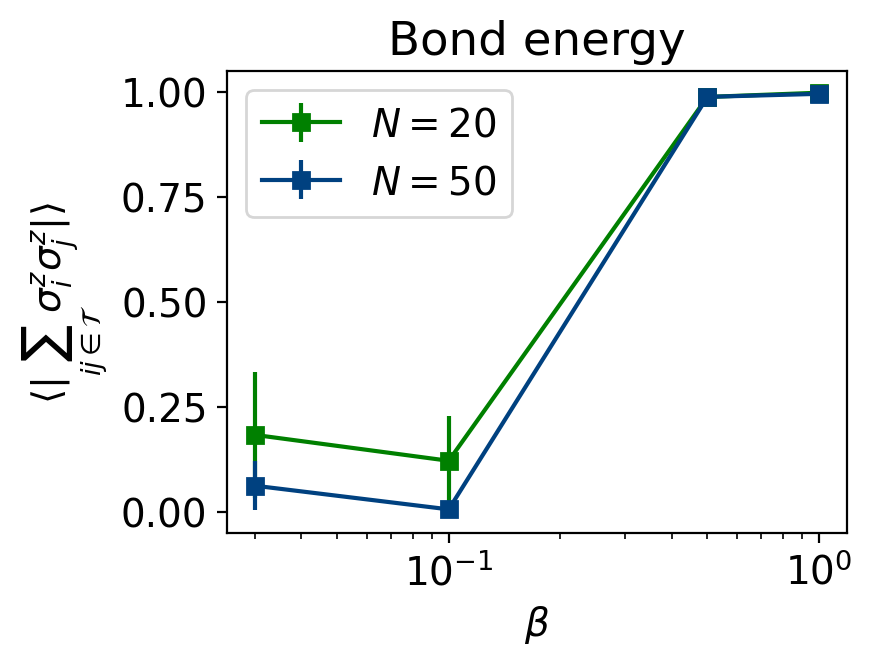

In [143]:
cmap = plt.colormaps['ocean']
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size':14})
plt.figure(figsize=(4,3))

for i in range(len(npts_range)):
    yarr = np.zeros(len(beta_range))
    yerr = np.zeros(len(beta_range))
    for j in range(len(beta_range)):    
        ene_array = np.array(data["Npts={:.0f}_beta={:.2f}".format(npts_range[i], beta_range[j])]['enes'])
        yarr[j] = np.mean(np.abs(ene_array))
        # yarr[j] = np.mean(mag_array)
        yerr[j] = np.mean(ene_array**2) -  (np.mean(ene_array))**2
    plt.errorbar(beta_range, yarr, yerr = yerr, fmt = 's-', label = r'$N = ${:.0f}'.format(npts_range[i]), color = cmap(i/len(npts_range)))

plt.title('Bond energy')
plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle | \sum_{ij \in \mathcal{T}} \sigma_i^z \sigma_j^z| \rangle$')
plt.legend()